In [3]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random


In [4]:
import pandas as pd
# Read Data
data = pd.read_csv('./UrbanSound8K/metadata/UrbanSound8K.csv')
data.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
data.shape

(8732, 8)

In [6]:
# Get data over 3 seconds long
valid_data = data[['slice_file_name', 'fold' ,'classID', 'class']][ data['end']-data['start'] >= 1 ]
valid_data.shape

(8276, 4)

In [7]:
!pip install librosa
import librosa.display
y, sr = librosa.load('./UrbanSound8K/audio/fold6/135160-8-0-0.wav', duration=2.97)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 128)

C:\Users\ASELSAN\anaconda3\envs\hintern\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\ASELSAN\anaconda3\envs\hintern\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


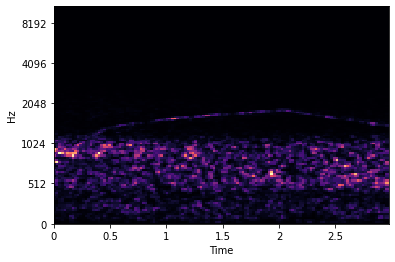

In [8]:
import librosa
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [9]:
valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype('str')

In [10]:
D = [] # Dataset

for row in valid_data.itertuples():
    y, sr = librosa.load('./UrbanSound8K/audio/' + row.path, duration=2.97)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    if ps.shape != (128, 128): continue
    ps= ps.flatten()
    D.append( (ps, row.classID) )

C:\Users\ASELSAN\anaconda3\envs\hintern\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: './UrbanSound8K/audio/fold10/100648-1-1-0.wav'

In [ ]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random

dataset = D
random.shuffle(dataset)

train = dataset[:7000]
test = dataset[7000:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test = np.array(keras.utils.to_categorical(y_test, 10))

model = Sequential()
input_shape=(128, 128, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=12,
    batch_size=128,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])